In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle
from scipy import integrate
from car_park_functions import *
import math

In [5]:
available_parkings = ['Vilanova', 'SantSadurni', 'SantBoi', 'QuatreCamins',
                      'Cerdanyola','Granollers','Martorell','Mollet',
                      'SantQuirze','PratDelLlobregat']
df_column_name=['Parking Vilanova Renfe','Parking Sant Sadurní Renfe','Parking Sant Boi de Llobregat',
              'Parking Quatre Camins','Cerdanyola Universitat Renfe','Parking Granollers Renfe',
                'Parking Martorell FGC','Parking Mollet Renfe','Parking Sant Quirze FGC',
               'Parking Prat del Ll.']
current_parking_ix=3
# problems on Weekend with 2 SantBoi, 4 Cerdanyola, 
# bad data: 6 Martorell, 8 SantQuirze DO NOT USE
#good 0 Vilanova, 1 SantSadurni, 4 QuatreCamins, 5 Granollers, 7 Mollet, 9 PratDelLlobregat 
current_parking = available_parkings[current_parking_ix]
current_column_name=df_column_name[current_parking_ix]


# loadind data:
    # Getting back the objects:
with open('data/'+current_parking+'_normalized.pkl','rb') as f:  # Python 3: open(..., 'rb')
    df_normalized, weekday_offset, friday_offset,  weekend_offset, max_value= pickle.load(f)
    f.close()
axis_ylim = max_value+20

df_training, df_testing = split_data(df_normalized, 3)



df_mean_areas = df_training.groupby(['Profile_3'], as_index=False).mean() 
df_mean_areas[['Profile_3', 'Area']]

friday_area = df_mean_areas.iloc[0]['Area']
weekday_area = df_mean_areas.iloc[1]['Area']
weekend_area = df_mean_areas.iloc[2]['Area']

friday_max = df_mean_areas.iloc[0]['MaxV']
weekday_max = df_mean_areas.iloc[1]['MaxV']
weekend_max = df_mean_areas.iloc[2]['MaxV']

print('Weekday area: ' , weekday_area)
print('Friday area: ' , friday_area)
print('Weekend area: ' , weekend_area)

print('Weekday maximum: ' , weekday_max)
print('Friday maximum: ' , friday_max)
print('Weekend maximum: ' , weekend_max)

Weekday area:  3516.6577380952117
Friday area:  3082.0952380952285
Weekend area:  523.6141262509632
Weekday maximum:  144.64285714285714
Friday maximum:  140.71428571428572
Weekend maximum:  26.775981524249424


## MATHEMATICAL MODEL - CDF Subtraction

In [25]:
# ********************************************** WEEKDAY *************************************************************
#from scipy.special import tna, factorial
from scipy.optimize import minimize
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
time = np.linspace(0,23.5,48)
time_tn=time/24


#training_weekdays_norm  = get_days_of_protos_normalized("Weekday", df_training)
#training_fridays_norm  = get_days_of_protos_normalized("Friday", df_training)
#training_weekends_norm  = get_days_of_protos_normalized("Weekend", df_training)
training_weekdays_norm  = get_days_of_protos_areanormalized("Weekday", df_training)
training_fridays_norm  = get_days_of_protos_areanormalized("Friday", df_training)
training_weekends_norm  = get_days_of_protos_areanormalized("Weekend", df_training)

training_weekends_norm = training_weekends_norm[:-1]

training_weekdays_isfull  = get_parkingfull_of_protos("Weekday", df_training)
training_weekdays_date  =  get_dates_of_protos("Weekday", df_training)
training_fridays_isfull  = get_parkingfull_of_protos("Friday", df_training)
training_fridays_date  =  get_dates_of_protos("Friday", df_training)
training_weekends_date  =  get_dates_of_protos("Weekday", df_training)

# training_weekends_norm = t
wd_length = len(training_weekdays_norm)
f_length = len(training_fridays_norm)
we_length = len(training_weekends_norm)

parameters_tn = np.array([.2 ,.05,.7,.1])
#optimal_params_weekdaytn = minimize(model_tn_areaN, parameters_tn, args=(training_weekdays_norm), method='Nelder-Mead',
#                                    tol=1e-6, options={'disp': True})

errors = np.ones(np.shape(training_weekdays_norm))
optimal_params_weekdaytn = minimize(model_tn_areaN_args,
                                    parameters_tn, 
                                    args=(training_weekdays_norm, errors),
                                    method='Nelder-Mead',
                                    tol=1e-6, options={'disp': True, 'maxfev': 10000})



Optimization terminated successfully.
         Current function value: 0.007182
         Iterations: 190
         Function evaluations: 323


In [7]:
import math 
var_weekdaytn_time = np.mean(errors)
stdv_weekdaytn=math.sqrt(var_weekdaytn_time)
print('global stdv %.5f\n' % stdv_weekdaytn)
stdv_weekday30mins = np.sqrt(np.mean(errors,0))
print('stdv per time-step')
for i in stdv_weekday30mins:
    print('\t' + str(i))

global stdv 0.00231

stdv per time-step
	0.0014573612639332528
	0.0013711995973639257
	0.0013121071222354276
	0.0013127497153044437
	0.0013153345755760398
	0.0013169823921825175
	0.0013146523701303484
	0.0013031655233144183
	0.0012999013676564255
	0.0013218719180330954
	0.0016055766509228942
	0.0019230504159732428
	0.0020006131164554733
	0.0026003823864339144
	0.0024993629998500424
	0.002804961369342825
	0.003116688537552396
	0.0021927038719372805
	0.0023643780526622377
	0.002506323778781629
	0.0025817038531690414
	0.0026413118574923917
	0.0027612040741147917
	0.002834793055805461
	0.0026834901337509224
	0.002656503121277111
	0.002654704547451
	0.002550851772356113
	0.0024642792971149227
	0.0024820990610295948
	0.00214695599308043
	0.001984047570141666
	0.002129780148620216
	0.002293193919972291
	0.001955688226190357
	0.0027462219911227152
	0.002536145779806665
	0.0024193321952858736
	0.003053360687681956
	0.0030857451761146194
	0.002821999878577243
	0.0026934072947951662
	0.0025662632

In [8]:
optimal_params_weekdaytn

 final_simplex: (array([[0.30350063, 0.02959791, 0.8057803 , 0.07834087],
       [0.30350048, 0.02959731, 0.80578042, 0.07834103],
       [0.30350054, 0.02959748, 0.80578077, 0.07834033],
       [0.30350084, 0.02959737, 0.80578073, 0.07834165],
       [0.30350085, 0.02959741, 0.80578021, 0.07834097]]), array([0.00718209, 0.00718209, 0.00718209, 0.00718209, 0.00718209]))
           fun: 0.007182093096028476
       message: 'Optimization terminated successfully.'
          nfev: 323
           nit: 190
        status: 0
       success: True
             x: array([0.30350063, 0.02959791, 0.8057803 , 0.07834087])

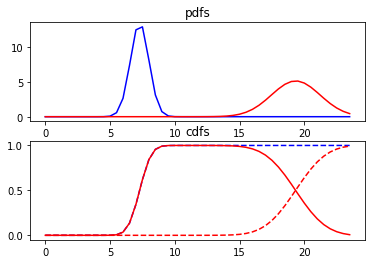

In [9]:
plot_model_tn(optimal_params_weekdaytn.x[0],optimal_params_weekdaytn.x[1],optimal_params_weekdaytn.x[2],optimal_params_weekdaytn.x[3])

In [10]:
weekday_math_params = optimal_params_weekdaytn.x
weekday_math_params

array([0.30350063, 0.02959791, 0.8057803 , 0.07834087])

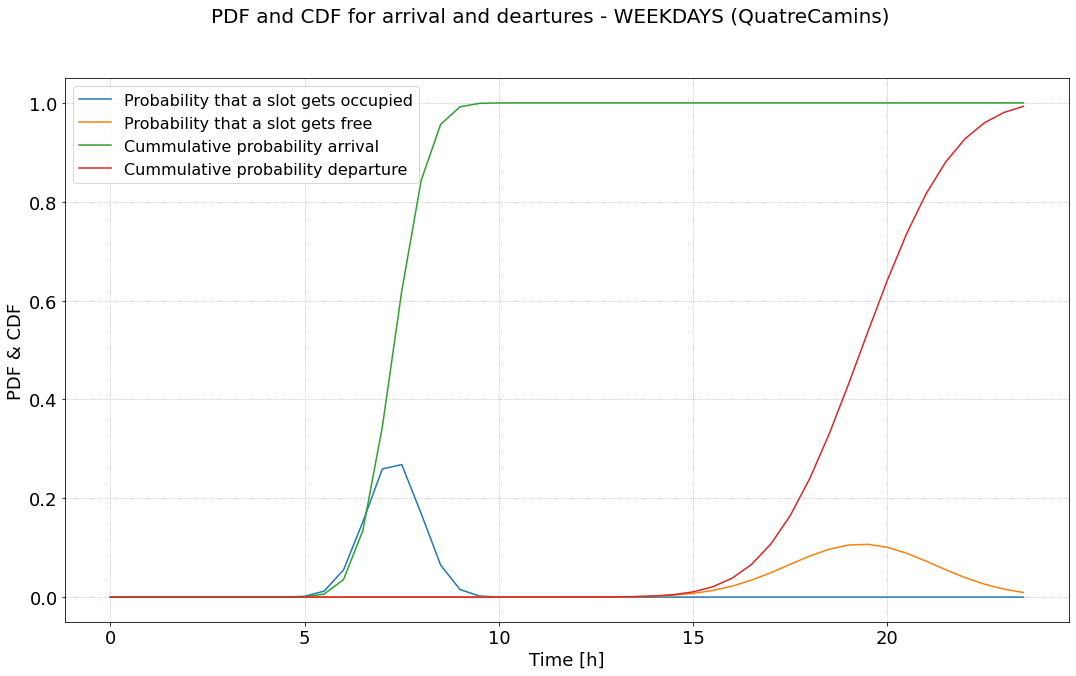

In [11]:
time2 = np.linspace(0,23.5,48)
time_tn=time2/24
tn1_wd=tn(time_tn, optimal_params_weekdaytn.x[0], optimal_params_weekdaytn.x[1])
tn2_wd=tn(time_tn, optimal_params_weekdaytn.x[2], optimal_params_weekdaytn.x[3])
#tn1_wd = gam(time2, optimal_params_weekday.x[0], optimal_params_weekday.x[1])
#tn2_wd = gam(time2, optimal_params_weekday.x[2], optimal_params_weekday.x[3])

#cdf1_wd_ap = generate_cdf(tn1_wd)
#cdf2_wd_ap = generate_cdf(tn2_wd)
cdf1_wd = tn_cdf(time_tn, optimal_params_weekdaytn.x[0], optimal_params_weekdaytn.x[1])
cdf2_wd = tn_cdf(time_tn, optimal_params_weekdaytn.x[2], optimal_params_weekdaytn.x[3])
#cdf1_wd = generate_cdf(tn1_wd)
#cdf2_wd = generate_cdf(tn2_wd)

resta_wd = np.array(cdf1_wd) - np.array(cdf2_wd)
prototype_math_weekday = resta_wd/sum(resta_wd)

#resta_wd_ap= np.array(cdf1_wd_ap) - np.array(cdf2_wd_ap)
#prototype_math_weekday_ap = resta_wd_ap/sum(resta_wd_ap)

fig = plt.figure(figsize=(18,10))
fig.suptitle("PDF and CDF for arrival and deartures - WEEKDAYS ("+current_parking+")", fontsize=20)
plt.plot(time2, tn1_wd/sum(tn1_wd), label="Probability that a slot gets occupied")
plt.plot(time2, tn2_wd/sum(tn2_wd),  label="Probability that a slot gets free")
plt.plot(time2, cdf1_wd, label="Cummulative probability arrival")
plt.plot(time2, cdf2_wd, label="Cummulative probability departure")
#plt.plot(time2, cdf1_wd_ap, label="Cummulative probability arrival approx")
#plt.plot(time2, cdf2_wd_ap, label="Cummulative probability departure approx")
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=18)
plt.ylabel("PDF & CDF", fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.legend(fontsize=16, loc="upper left");


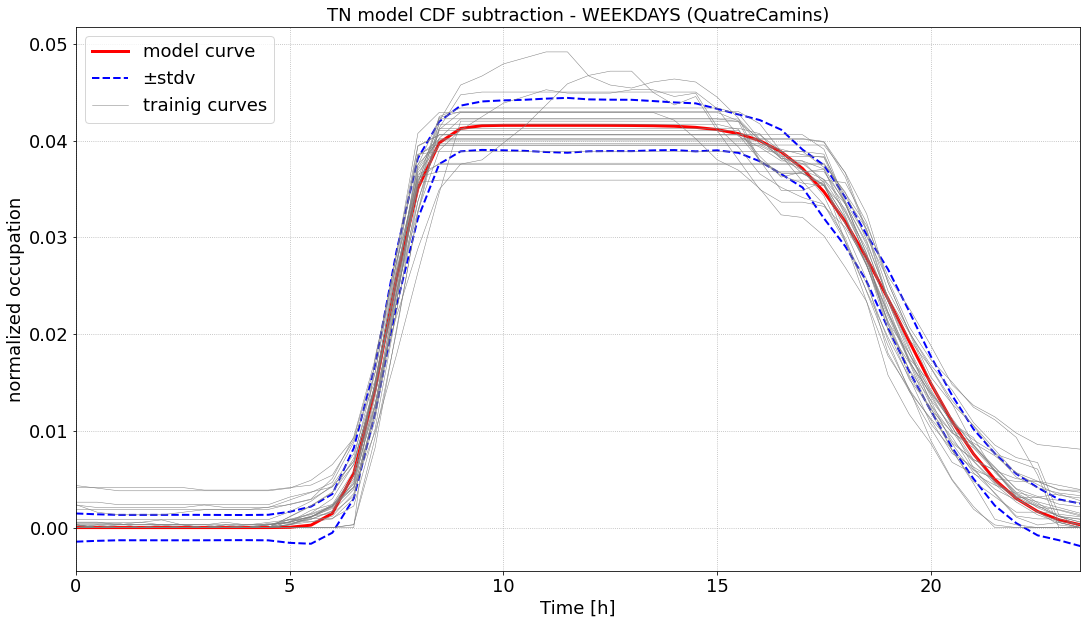

In [12]:
fsize=18
fig = plt.figure(figsize=(18,10))
plt.title("TN model CDF subtraction - WEEKDAYS ("+current_parking+")", fontsize=fsize)
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=fsize)
plt.ylabel("normalized occupation", fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.plot(time2, prototype_math_weekday-stdv_weekday30mins, linewidth=2, linestyle='--', color='blue')
plt.plot(time2, prototype_math_weekday, linewidth=3, color='red', label="model curve")
plt.plot(time2, prototype_math_weekday+stdv_weekday30mins, linewidth=2, linestyle='--', color='blue', label="±stdv")
#plt.plot(time2, prototype_math_weekday_ap, linewidth=3, color='red', label="approx")
for i in range(0,len(training_weekdays_norm)):
    if i==0:
        plt.plot(time, training_weekdays_norm[i], linewidth=0.5, color='gray', label="trainig curves")
    else:
        plt.plot(time, training_weekdays_norm[i], linewidth=0.5, color='gray')

plt.xlim([0,23.5])
plt.legend(fontsize=fsize, loc="upper left");
fig.savefig('Training_'+current_parking+'.pdf',bbox_inches='tight');
fig.savefig('Training_'+current_parking+'.png',bbox_inches='tight');

### FRIDAYS

In [13]:
parameters_tn = np.array([.2 ,.05,.7,.1])
#optimal_params_fridaytn = minimize(model_tn_areaN, parameters_tn, args=(training_fridays_norm), method='Nelder-Mead',
#                                    tol=1e-6, options={'disp': True})

errors = np.ones(np.shape(training_fridays_norm))
optimal_params_fridaytn = minimize(model_tn_areaN_args,
                                    parameters_tn, 
                                    args=(training_fridays_norm, errors),
                                    method='Nelder-Mead',
                                    tol=1e-6, options={'disp': True})


Optimization terminated successfully.
         Current function value: 0.002139
         Iterations: 135
         Function evaluations: 243


In [14]:
var_fridaytn = np.mean(errors)
stdv_fridaytn=math.sqrt(var_fridaytn)
print('global stdv %.5f\n' % stdv_fridaytn)
stdv_friday30mins = np.sqrt(np.mean(errors,0))
print('stdv per time-step')
for i in stdv_friday30mins:
    print('\t' + str(i))

global stdv 0.00252

stdv per time-step
	0.0005585026731533105
	0.00039157646486683744
	0.00029612182926544016
	0.00022916207393125441
	0.0002568553938175072
	0.0002568560104002579
	0.000229163502891975
	0.00022915599298340293
	0.00025600588174931187
	0.0003699570400685029
	0.000745431952260477
	0.0010319288132410126
	0.0010549482227486997
	0.002031106525873048
	0.0010966142849730533
	0.00165663119956947
	0.002643311561081203
	0.0024543136921220668
	0.0030739400156381733
	0.003689766447398058
	0.003530803149723951
	0.003220188125040288
	0.0029191495929561328
	0.0028007178534259452
	0.002864039390250013
	0.0029289859473900486
	0.0032125400336576134
	0.0037307395083469455
	0.004414009610932906
	0.004619371530877711
	0.003568966748557717
	0.001974623179465501
	0.003745200490156208
	0.004078596265444669
	0.003355644249395201
	0.0022648135219929624
	0.0023384015236979955
	0.001887392792501656
	0.0020884485319895853
	0.0027123749712027008
	0.0025465399542626776
	0.0021578245627759517
	0.0024

In [15]:
optimal_params_fridaytn

 final_simplex: (array([[0.30795902, 0.03340294, 0.76307383, 0.12298193],
       [0.307959  , 0.03340245, 0.76307403, 0.12298155],
       [0.30795926, 0.03340265, 0.76307425, 0.12298107],
       [0.30795898, 0.03340276, 0.76307348, 0.12298102],
       [0.30795895, 0.03340294, 0.76307441, 0.12298107]]), array([0.00213942, 0.00213942, 0.00213942, 0.00213942, 0.00213942]))
           fun: 0.002139422848213427
       message: 'Optimization terminated successfully.'
          nfev: 243
           nit: 135
        status: 0
       success: True
             x: array([0.30795902, 0.03340294, 0.76307383, 0.12298193])

In [16]:
#optimal_params_friday.x
#friday_math_params = optimal_params_friday.x
friday_math_params = optimal_params_fridaytn.x

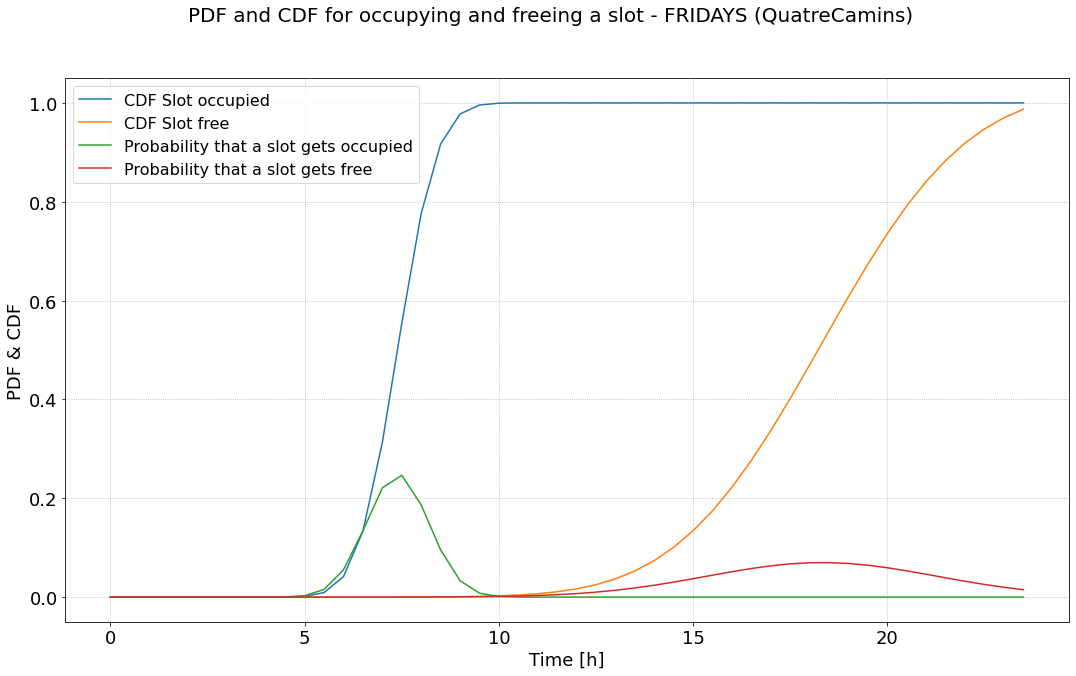

In [17]:

#tn1_fri = gam(time, optimal_params_friday.x[0], optimal_params_friday.x[1])
#tn2_fri = gam(time, optimal_params_friday.x[2], optimal_params_friday.x[3])
tn1_fri=tn(time_tn, optimal_params_fridaytn.x[0], optimal_params_fridaytn.x[1])
tn2_fri=tn(time_tn, optimal_params_fridaytn.x[2], optimal_params_fridaytn.x[3])

#cdf1_fri = generate_cdf(tn1_fri)
#cdf2_fri = generate_cdf(tn2_fri)
#cdf1_fri = generate_cdf(tn1_fri)
#cdf2_fri = generate_cdf(tn2_fri)
cdf1_fri=tn_cdf(time_tn, optimal_params_fridaytn.x[0], optimal_params_fridaytn.x[1])
cdf2_fri=tn_cdf(time_tn, optimal_params_fridaytn.x[2], optimal_params_fridaytn.x[3])

resta = np.array(cdf1_fri) - np.array(cdf2_fri)
prototype_math_friday = resta/sum(resta)
fig = plt.figure(figsize=(18,10))
fig.suptitle("PDF and CDF for occupying and freeing a slot - FRIDAYS ("+current_parking+")", fontsize=20)
plt.plot(time, cdf1_fri, label="CDF Slot occupied")
plt.plot(time, cdf2_fri, label="CDF Slot free")
plt.plot(time, tn1_fri/sum(tn1_fri), label="Probability that a slot gets occupied")
plt.plot(time, tn2_fri/sum(tn2_fri),  label="Probability that a slot gets free")
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=18)
plt.ylabel("PDF & CDF", fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.legend(fontsize=16, loc="upper left")

plt.legend(fontsize=16)

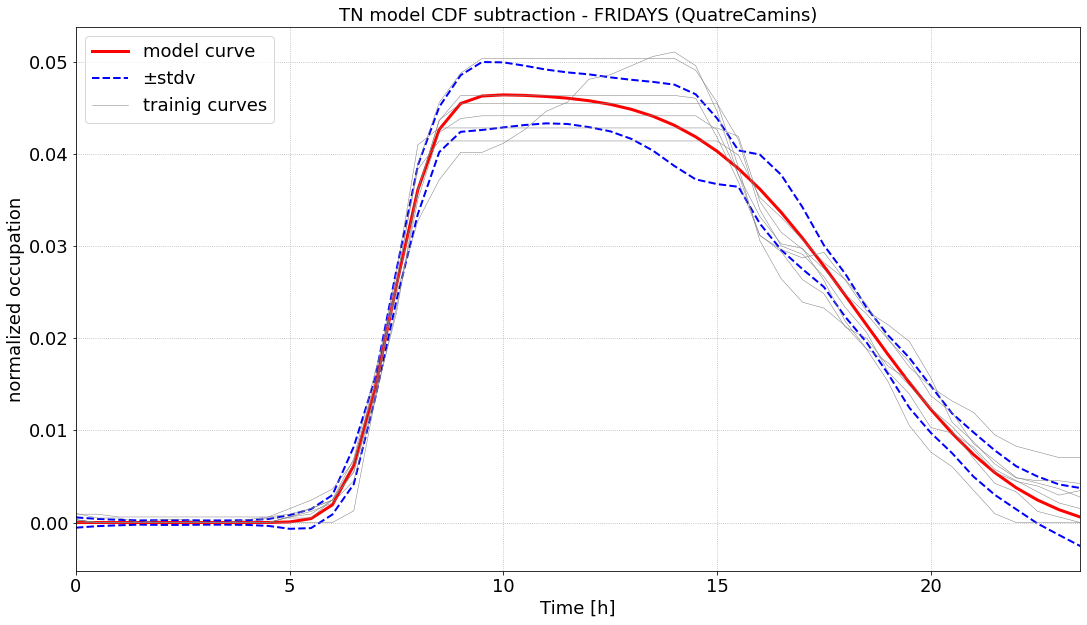

In [18]:
fsize=18
fig = plt.figure(figsize=(18,10))
plt.title("TN model CDF subtraction - FRIDAYS ("+current_parking+")", fontsize=fsize)
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=fsize)
plt.ylabel("normalized occupation", fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.plot(time2, prototype_math_friday-stdv_friday30mins, linewidth=2, linestyle='--', color='blue')
plt.plot(time2, prototype_math_friday, linewidth=3, color='red', label="model curve")
plt.plot(time2, prototype_math_friday+stdv_friday30mins, linewidth=2, linestyle='--', color='blue', label="±stdv")

#plt.plot(time2, prototype_math_weekday_ap, linewidth=3, color='red', label="approx")
for i in range(0,len(training_fridays_norm)):
    if i==0:
        plt.plot(time, training_fridays_norm[i], linewidth=0.5, color='gray', label="trainig curves")
    else:
        plt.plot(time, training_fridays_norm[i], linewidth=0.5, color='gray')

plt.xlim([0,23.5])
plt.legend(fontsize=fsize, loc="upper left");
fig.savefig('Training_'+current_parking+'_FRIDAY.pdf',bbox_inches='tight');

### WEEKENDS

In [26]:
parameters_tn = np.array([.2 ,.05,.7,.1])
errors = np.ones(np.shape(training_weekends_norm))    
if ((current_parking == "SantBoi") or (current_parking == "Cerdanyola")): 
    #optimal_params_weekendtn = minimize(model_tn_areaN_args, parameters_tn, args=(training_weekends_norm), method='SLSQP',
    #                                   bounds=((0, None), (0, None),(0, None),(0, None)),
    #                                    tol=1e-6, options={'disp': True, 'maxfev': 100000})
    optimal_params_weekendtn = minimize(model_tn_areaN_args,
                                    parameters_tn, 
                                    args=(training_weekends_norm, errors),
                                    method='SLSQP',
                                    bounds=((0, None), (0, None),(0, None),(0, None)),
                                    tol=1e-6, options={'disp': True, 'maxfev': 100000})
else:
    #optimal_params_weekendtn = minimize(model_tn_areaN_args, parameters_tn, args=(training_weekends_norm), method='Nelder-Mead',
    #                                    tol=1e-6, options={'disp': True, 'maxfev': 100000})     
    
    optimal_params_weekendtn = minimize(model_tn_areaN_args,
                                    parameters_tn, 
                                    args=(training_weekends_norm, errors),
                                    method='Nelder-Mead',
                                    tol=1e-6, options={'disp': True, 'maxfev': 100000})


Optimization terminated successfully.
         Current function value: 0.027368
         Iterations: 195
         Function evaluations: 328


In [27]:
var_weekendtn = np.mean(errors)
stdv_weekendtn=math.sqrt(var_weekendtn)
print('global stdv %.5f\n' % stdv_weekendtn)
stdv_weekend30mins = np.sqrt(np.mean(errors,0))
print('stdv per time-step')
for i in stdv_weekend30mins:
    print('\t' + str(i))

global stdv 0.00844

stdv per time-step
	0.010250939637818151
	0.007935372533627628
	0.007066307365113662
	0.006987465743920779
	0.006755766754553942
	0.006824393687569819
	0.006585888813019106
	0.006764750327581405
	0.006196426178927389
	0.0060799583510238705
	0.005970888448944764
	0.006639335421237403
	0.005547388782138927
	0.004693823970422777
	0.004836720599038547
	0.005140017459708937
	0.0052929159006529424
	0.005134395231079809
	0.006341530542555203
	0.006771477776789533
	0.007937613314733867
	0.006140216503961757
	0.005109106338311019
	0.006676551278530425
	0.007947409929510884
	0.008513952860434435
	0.006229885447461531
	0.00793332643024736
	0.0057732904891326375
	0.00842713247619283
	0.009168835307274466
	0.0072927560737761155
	0.0068863833453346865
	0.006966472969674858
	0.007125749071762692
	0.007079089597005442
	0.009868004888101757
	0.010485700307982983
	0.012009356304103738
	0.013916382242618998
	0.014662328079292807
	0.013997285391805909
	0.014331436181547905
	0.01453605

In [28]:
weekend_math_params = optimal_params_weekendtn.x
optimal_params_weekendtn.x

array([0.39530175, 0.08861594, 0.95355598, 0.10502728])

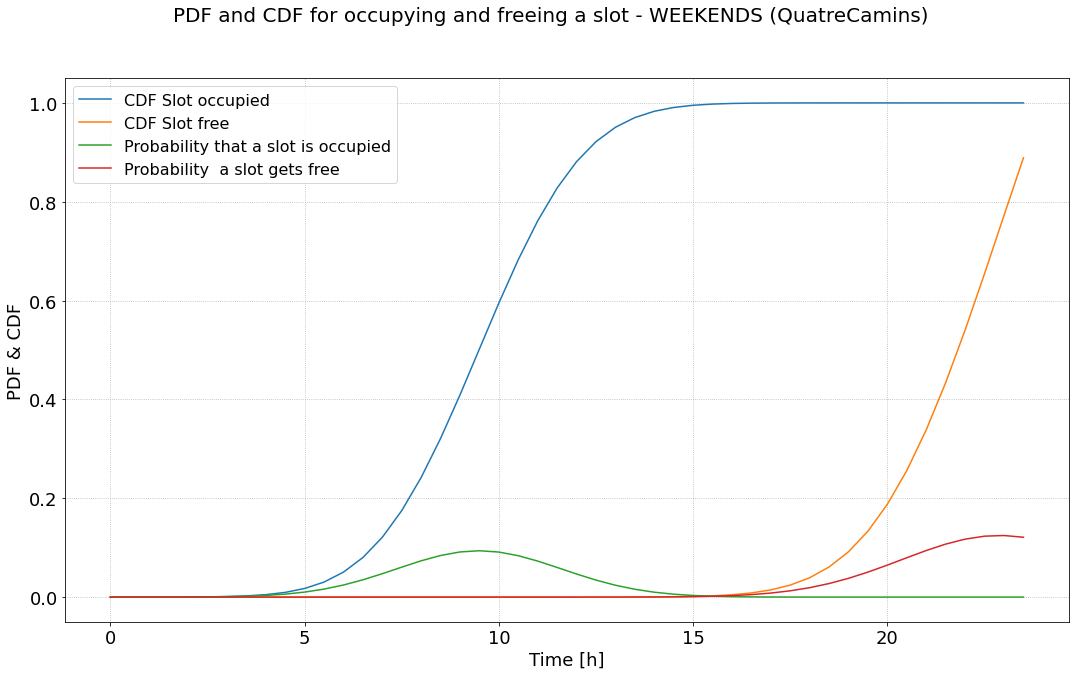

In [29]:
#tn1_we = gam(time, optimal_params_weekend.x[0], optimal_params_weekend.x[1])
#tn2_we = gam(time, optimal_params_weekend.x[2], optimal_params_weekend.x[3])
tn1_we=tn(time_tn, optimal_params_weekendtn.x[0], optimal_params_weekendtn.x[1])
tn2_we=tn(time_tn, optimal_params_weekendtn.x[2], optimal_params_weekendtn.x[3])



#cdf1_we = generate_cdf(tn1_we)
#cdf2_we = generate_cdf(tn2_we)
cdf1_we = tn_cdf(time_tn, optimal_params_weekendtn.x[0], optimal_params_weekendtn.x[1])
cdf2_we = tn_cdf(time_tn, optimal_params_weekendtn.x[2], optimal_params_weekendtn.x[3])



resta_we = np.array(cdf1_we) - np.array(cdf2_we)
prototype_math_weekend = resta_we/sum(resta_we)
fig = plt.figure(figsize=(18,10))
fig.suptitle("PDF and CDF for occupying and freeing a slot - WEEKENDS ("+current_parking+")", fontsize=20)
plt.plot(time, cdf1_we, label="CDF Slot occupied")
plt.plot(time, cdf2_we, label="CDF Slot free")
plt.plot(time, tn1_we/sum(tn1_we), label="Probability that a slot is occupied")
plt.plot(time, tn2_we/sum(tn2_we),  label="Probability  a slot gets free")
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=18)
plt.ylabel("PDF & CDF", fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.legend(fontsize=16, loc="upper left")

plt.legend(fontsize=16)

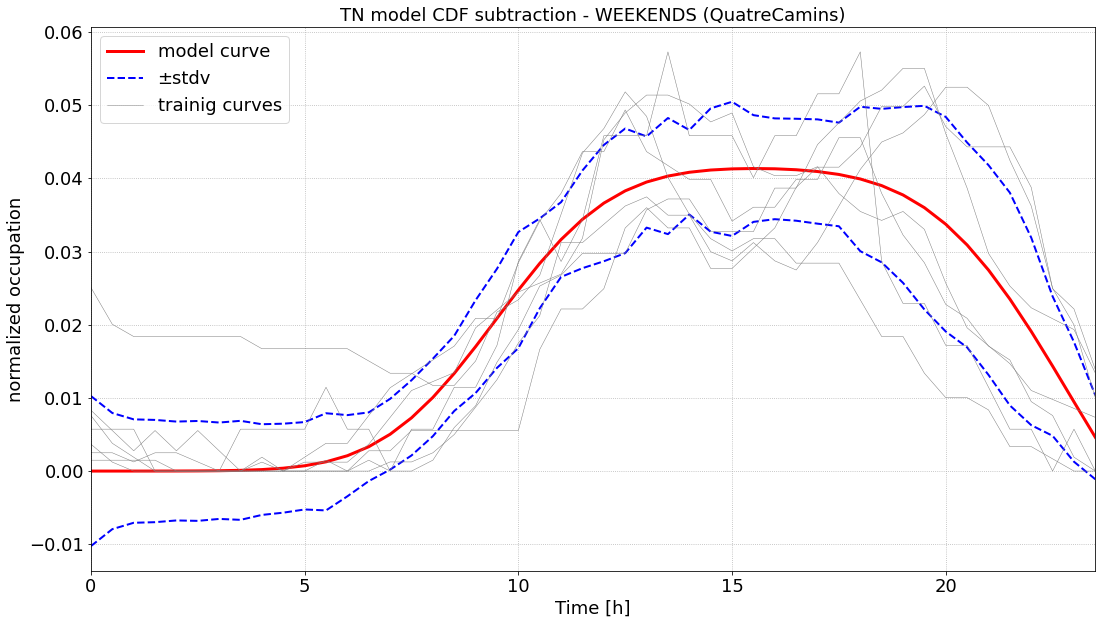

In [30]:
fsize=18
fig = plt.figure(figsize=(18,10))
plt.title("TN model CDF subtraction - WEEKENDS ("+current_parking+")", fontsize=fsize)
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=fsize)
plt.ylabel("normalized occupation", fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.plot(time2, prototype_math_weekend-stdv_weekend30mins, linewidth=2, linestyle='--', color='blue')
plt.plot(time2, prototype_math_weekend, linewidth=3, color='red', label="model curve")
plt.plot(time2, prototype_math_weekend+stdv_weekend30mins, linewidth=2, linestyle='--', color='blue', label="±stdv")

for i in range(0,len(training_fridays_norm)):
    if i==0:
        plt.plot(time, training_weekends_norm[i], linewidth=0.5, color='gray', label="trainig curves")
    else:
        plt.plot(time, training_weekends_norm[i], linewidth=0.5, color='gray')

plt.xlim([0,23.5])
plt.legend(fontsize=fsize, loc="upper left");
fig.savefig('Training_'+current_parking+'WEEKEND.pdf',bbox_inches='tight');

In [ ]:
printTimes(optimal_params_weekdaytn.x,current_parking,'WEEKDAYS')
printTimes(optimal_params_fridaytn.x,current_parking,'FRIDAYS')
printTimes(optimal_params_weekendtn.x,current_parking,'WEEKENDS')

In [ ]:
tn_weekday_n = prototype_math_weekday
tn_friday_n = prototype_math_friday
tn1_weekend_n = prototype_math_weekend

In [ ]:
fig, ax = plt.subplots(1,3)
fig.set_figwidth(20)
fig.set_figheight(4)
fig.suptitle('Decomoposition for each prototype [TN Probability Normalized] - ' + current_parking, fontsize=20)

# for ii in range(len(training_weekdays_norm)):
#     ax[0].plot(time,training_weekdays_norm[ii], linewidth='0.5')
ax[0].plot(time2, tn_weekday_n, linewidth=2, color= 'green', label='Mathematical Weekday fit')
ax[0].set_ylim([0,0.06])
ax[0].grid(linestyle='dotted')
ax[0].legend(fontsize=8)
ax[0].set_xlabel('Time (hour)')
ax[0].set_ylabel('Probability')

# for ii in range(len(training_fridays_norm)):
#     ax[1].plot(time,training_fridays_norm[ii], linewidth='0.5')
ax[1].plot(time2, tn_friday_n, linewidth=2, color= 'green', label='Mathematical Friday fit')
ax[1].set_ylim([0,0.06])
ax[1].grid(linestyle='dotted')
ax[1].legend(fontsize=9)
ax[1].set_xlabel('Time (hour)')
ax[1].set_ylabel('Probability')

# for ii in range(len(training_weekends_norm)):
#      ax[2].plot(time,training_weekends_norm[ii], linewidth='0.5')
ax[2].plot(time2, tn1_weekend_n, linewidth=2, color='green', label='Mathematical Weekend wave')
ax[2].set_ylim([0,0.06])
ax[2].grid(linestyle='dotted')
ax[2].legend()
ax[2].set_xlabel('Time (hour)')
ax[2].set_ylabel('Probability');

In [ ]:
#**************************************WEEKDAY************************************
tn_weekday = tn_weekday_n*weekday_area + weekday_offset

#**************************************FRIDAY************************************
tn_friday = tn_friday_n*friday_area + friday_offset

#**************************************WEEKEND************************************
tn1_weekend = tn1_weekend_n*weekend_area + weekend_offset 

### Comparing normalized mathematical fitted prototype with testing data

In [ ]:
def subplot_training(fig, ax, xx, yy, proto_data, test_days, day, proto_name): 
    ax[xx,yy].plot(time, proto_data, linewidth=3, linestyle='dashed', label= proto_name + ' TN prediction')
    for i in range(0, len(test_days)): 
        ax[xx, yy].plot(time, test_days[i], linewidth=1, label='Testing ' + day )
        if i==0:
            ax[xx,yy].legend(fontsize=16)
    ax[xx,yy].grid(linestyle='dotted')
    ax[xx,yy].set_ylim(-2,axis_ylim)
    ax[xx,yy].set_xlabel('Time (hours)', fontsize=16)
    ax[xx,yy].set_ylabel('Occupancy', fontsize=16)


### Denormalization / Rescaling

In [ ]:

tn_weekday = tn_weekday_n*weekday_area + weekday_offset
tn_friday = tn_friday_n*friday_area + friday_offset
tn1_weekend = tn1_weekend_n*weekend_area + weekend_offset 



In [ ]:
def compute_testing_prop_error(testing_days, proto_data):
    errors = np.zeros(48)
    n_test_days = len(testing_days)
    proto = np.array(proto_data)
    
    for i in range(0, n_test_days):
        day = np.array(testing_days[i])
        er = np.array((np.absolute(proto - day)/max_value)*100)
        errors += er
    return errors/n_test_days

error_monday_tn = compute_testing_prop_error(testing_mondays, tn_weekday)
error_tuesday_tn = compute_testing_prop_error(testing_tuesdays, tn_weekday)
error_wednesday_tn = compute_testing_prop_error(testing_wednesdays, tn_weekday)
error_thursday_tn = compute_testing_prop_error(testing_thursdays, tn_weekday)
error_friday_tn = compute_testing_prop_error(testing_fridays, tn_friday)
error_saturday_tn = compute_testing_prop_error(testing_saturdays, tn1_weekend)
error_sunday_tn = compute_testing_prop_error(testing_sundays, tn1_weekend)

def subplotCDFsubtractionErr(fig, ax, axx, axy, x, error, mean, title, day ):
    ax[axx,axy].plot(x, error, color="tomato", linewidth=2, zorder=10, label='Proportional error')
    ax[axx,axy].plot(x, mean, linewidth=1, linestyle='--' ,color='black', label='Mean error')
    ax[axx,axy].grid(linestyle='dotted')
    ax[axx,axy].set_ylabel('Proportional error %', fontsize=20)
    ax[axx,axy].set_xlabel('Hours', fontsize=20)
    ax[axx,axy].set_title(title , fontsize=20, pad=10)
    ax[axx,axy].set_ylim((0,1.1*max(error)))
    ax[axx,axy].legend(fontsize=16)
    ax[axx,axy].tick_params( labelsize=15)

    
fig, ax = plt.subplots(3, 3)
fig.set_figwidth(20)
fig.set_figheight(12)
fig.suptitle('Offline prediction through mathematical modeling ERROR - '+current_parking+' (Denormalized)', fontsize=24)
time = np.linspace(0,23.5,48)

mean_Monday =  [np.mean(error_monday_tn)]*len(time)
subplotCDFsubtractionErr(fig, ax, 0, 0, time, error_monday_tn, mean_Monday, 
                 'Proportional error Monday ', 'Monday')

mean_Tuesday =  [np.mean(error_tuesday_tn)]*len(time)
subplotCDFsubtractionErr(fig, ax, 0, 1, time, error_tuesday_tn, mean_Tuesday, 
                 'Proportional error Tuesday ', 'Tuesday')

mean_Wednesday =  [np.mean(error_wednesday_tn)]*len(time)
subplotCDFsubtractionErr(fig, ax, 0, 2, time, error_wednesday_tn, mean_Wednesday, 
                 'Proportional error Wednesday ', 'Wednesday')

mean_Thursday =  [np.mean(error_thursday_tn)]*len(time)
subplotCDFsubtractionErr(fig, ax, 1, 0, time, error_thursday_tn, mean_Thursday, 
                 'Proportional error Thursday ', 'Thursday')

mean_Friday =  [np.mean(error_friday_tn)]*len(time)
subplotCDFsubtractionErr(fig, ax, 1, 1, time, error_friday_tn, mean_Friday, 
                 'Proportional error Friday ', 'Friday')

mean_Saturday =  [np.mean(error_saturday_tn)]*len(time)
subplotCDFsubtractionErr(fig, ax, 1, 2, time, error_saturday_tn, mean_Saturday, 
                 'Proportional error Saturday ', 'Saturday')

mean_Sunday =  [np.mean(error_sunday_tn)]*len(time)
subplotCDFsubtractionErr(fig, ax, 2, 1, time, error_sunday_tn, mean_Sunday, 
                 'Proportional error Sunday ', 'Sunday')

ax[2,0].set_visible(False)
ax[2,2].set_visible(False)
fig.tight_layout(pad=5.0)
for ax in ax.flat:
    ax.set_ylabel('PROPORTIONAL ERROR %', fontsize=10)
    ax.set_xlabel('HOUR', fontsize=11)


print('______MEAN________')    

print(mean_Monday[0])
print(mean_Tuesday[0])
print(mean_Wednesday[0])
print(mean_Thursday[0])
print(mean_Friday[0])
print(mean_Saturday[0])
print(mean_Sunday[0])

print('______STDV________')

print(np.std(error_monday_tn))
print(np.std(error_tuesday_tn))
print(np.std(error_wednesday_tn))
print(np.std(error_thursday_tn))
print(np.std(error_friday_tn))
print(np.std(error_saturday_tn))
print(np.std(error_sunday_tn))


### MATHEMATICAL PROTOTYE: Real time prediction by SCALING

In [ ]:
# Plotting methods to reduce cell dimension

def real_timing_predition(fig, ax, axx, day, tn_proto, real_day, scaled_proto, Prototype, limit_hour, t_date):
    fig.suptitle('Real time prediction Scaling mathematical and mean proto for Testing '
                 + day + ' ' +t_date + ' ('+ current_parking+')', fontsize='18')
    ax[axx].plot(time, real_day.values, linestyle='dashdot', linewidth=2, label='Real ' + day)
    ax[axx].plot(time, tn_proto,'--',color='grey', label='TN prototype (not scaled)')
    ax[axx].plot(time, scaled_proto, color='green', linewidth=2, label='TN proto (scaled)')
    ax[axx].plot(time, Prototype, color='orange', linewidth=2, label='Stat. scaled proto')
    ax[axx].axvline(x=limit_hour, linestyle='--', color='grey', linewidth=2, label='Moment of prediction')
    ax[axx].axvspan(0, limit_hour, facecolor='grey', alpha=0.2, label='Known Activity')
    ax[axx].grid(linestyle='dotted', linewidth='0.5', color='grey')
    ax[axx].legend(fontsize=9)
    ax[axx].set_ylim([0,1.1*max([max(real_day.values),max(tn_proto),max(scaled_proto),max(Prototype)])])
    ax[axx].set_xlabel('Hour', fontsize=14)
    ax[axx].set_ylabel('Occupancy', fontsize=14)

def errors_plotting(fig, ax, axx, scaled_proto, Prototype, real_day, day, limit_hour):
    #Computing Errors
    limit_hour = limit_hour*2
    tn_scaled_error = (np.absolute((np.array(scaled_proto) - np.array(real_day.values)))/max_value)*100
    mean_scaled_error = (np.absolute((np.array(Prototype) - np.array(real_day.values)))/max_value)*100

    tn_s_error_mean = [np.mean(tn_scaled_error[limit_hour:])]*len(tn_scaled_error)
    mean_s_error_mean = [np.mean(mean_scaled_error[limit_hour:])]*len(mean_scaled_error)

    #Second plot
#     time = time[limit_hour:]
    ax[axx].plot(time[limit_hour:], tn_scaled_error[limit_hour:], color='tomato', label='TN scaling error')
    ax[axx].plot(time[limit_hour:],tn_s_error_mean[limit_hour:], '--',color='tomato', label='TN Mean prop. error')
    ax[axx].plot(time[limit_hour:],mean_scaled_error[limit_hour:], color='blueviolet', label='Proto scaling error')
    ax[axx].plot(time[limit_hour:],mean_s_error_mean[limit_hour:], '--',color='blueviolet', label='Proto. Mean prop. error')
    ax[axx].grid(linestyle='dotted', linewidth='0.5', color='grey')
    ax[axx].axvline(x=limit_hour/2, linestyle='--', color='grey', linewidth=2, label='Moment of prediction')
    ax[axx].axvspan(0, limit_hour/2, facecolor='grey', alpha=0.2, label='Known Activity', zorder=4)
    ax[axx].legend(fontsize=12)
    ax[axx].set_ylim([0,1.1*max(max(tn_scaled_error[limit_hour:]),max(mean_scaled_error[limit_hour:]))])
    ax[axx].set_xlabel('Hour', fontsize=14)
    ax[axx].set_ylabel('Proportional error (%)', fontsize=14)

    print('Real ' + day + ' scaled prtotype error: ', round(100*mean_s_error_mean[0])/100, '%')
    print('Real ' + day + ' scaled prtotype STDV: ', np.std(mean_scaled_error[limit_hour:]))

    print('Real ' + day + ' scaled TN error: ', round(100*tn_s_error_mean[0])/100, '%')
    print('Real ' + day + ' scaled TN STDV: ', np.std(tn_scaled_error[limit_hour:]))
    print('_____________________________________________________________')

def get_scaling_factor(limit_hour, test_day, proto):
    if limit_hour < 6:
        return 1
    index = limit_hour*2
    current_real_data = test_day.values[index]
    proto_value = proto[index]
    scaling = current_real_data/proto_value
    return scaling

#### MONDAY

In [ ]:
statistic_proto = hist_weekday_proto
tn_proto = tn_weekday
t_days = testing_mondays
t_dates=testing_mondays_dates
limit_hour = 16
day = 'Monday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], hist_weekday_proto.values)
    
    scaled_tn_proto = tn_proto * tn_scaling
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(5)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], scaled_tn_proto, scaled_stat_proto, limit_hour, t_date)
    axx=1;
    errors_plotting(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour)
    cont=cont+1

#### TUESDAY

In [ ]:
statistic_proto = hist_weekday_proto
tn_proto = tn_weekday
t_days = testing_tuesdays
t_dates= testing_tuesdays_dates
limit_hour = 10
day = 'Tuesday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], hist_weekday_proto.values)
    
    scaled_tn_proto = tn_proto * tn_scaling
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], scaled_tn_proto, scaled_stat_proto, limit_hour, t_date)
    axx=1;
    errors_plotting(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour)
    cont=cont+1

### WEDNESDAY

In [ ]:
statistic_proto = hist_weekday_proto
tn_proto = tn_weekday
t_days = testing_wednesdays
t_dates= testing_wednesdays_dates
limit_hour = 13
day = 'Wednesday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0

cont=0        
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], hist_weekday_proto.values)
    
    scaled_tn_proto = tn_proto * tn_scaling
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], scaled_tn_proto, scaled_stat_proto, limit_hour, t_date)
    axx=1;
    errors_plotting(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour)
    cont=cont+1

### THURSDAY

In [ ]:
statistic_proto = hist_weekday_proto
tn_proto = tn_weekday
t_days = testing_thursdays
t_dates= testing_thursdays_dates
limit_hour = 13
day = 'Thursday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0
        
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], hist_weekday_proto.values)
    
    scaled_tn_proto = tn_proto * tn_scaling
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], scaled_tn_proto, scaled_stat_proto, limit_hour, t_date)
    axx=1;
    errors_plotting(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour)
    cont=cont+1
    

### FRIDAY

In [ ]:
statistic_proto = hist_friday_proto
tn_proto = tn_friday
t_days = testing_fridays
t_dates=testing_fridays_dates
limit_hour = 16
day = 'Friday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0
  
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], statistic_proto.values)
    
    scaled_tn_proto = tn_proto * tn_scaling
    scaled_stat_proto = statistic_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], scaled_tn_proto, scaled_stat_proto, limit_hour, t_date)
    axx=1;
    errors_plotting(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour)
    cont=cont+1
    

### WEEKEND

### SATURDAY

In [ ]:
statistic_proto = hist_weekend_proto
tn_proto = tn1_weekend
t_days = testing_saturdays
t_dates= testing_saturdays_dates
limit_hour = 16
day = 'Saturday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0
        
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], statistic_proto.values)
    
    scaled_tn_proto = tn_proto * tn_scaling
    scaled_stat_proto = statistic_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], scaled_tn_proto, scaled_stat_proto, limit_hour, t_date)
    #ax[0].set_ylim([0,axis_ylim_we])
    axx=1;
    errors_plotting(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour)
    cont=cont+1

### SUNDAY

In [ ]:
statistic_proto = hist_weekend_proto
tn_proto = tn1_weekend
t_days = testing_sundays
t_dates= testing_sundays_dates
limit_hour = 13
day = 'Sunday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0
    
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], statistic_proto.values)
    
    scaled_tn_proto = tn_proto * tn_scaling
    scaled_stat_proto = statistic_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], scaled_tn_proto, scaled_stat_proto, limit_hour, t_date)
    #ax[0].set_ylim([0,axis_ylim_we])
    axx=1;
    errors_plotting(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour)
    cont=cont+1

# Store protos, params, areas and offsets

In [ ]:
# df_prototypes = pd.read_csv('data/prototypes_new.csv')
# index = 0

# weekday_tn_params = ','.join(str(e) for e in list(res_weekday.x))
# friday_tn_params  = ','.join(str(e) for e in list(res_friday.x))
# weekend_tn_params = ','.join(str(e) for e in list(res_weekend.x))

# weekday_mean_area = weekday_area
# friday_mean_area  = friday_area
# weekend_mean_area = weekend_area

# weekday_mean_offset = weekday_offset
# friday_mean_offset  = friday_offset
# weekend_mean_offset = weekend_offset

# total_wave_weekday_s = ','.join(str(e) for e in tn_weekday.tolist())
# total_wave_weekend_s = ','.join(str(e) for e in tn1_weekend.tolist())
# total_wave_friday_s  = ','.join(str(e) for e in tn_friday.tolist())

# historical_weekday_s = ','.join(str(e) for e in hist_weekday_proto.tolist())
# historical_weekend_s = ','.join(str(e) for e in hist_weekend_proto.tolist())
# historical_friday_s  = ','.join(str(e) for e in hist_friday_proto.tolist())


# df_prototypes.at[index,'CDF subtraction_weekday_proto'] = total_wave_weekday_s
# df_prototypes.at[index,'CDF subtraction_friday_proto']  = total_wave_friday_s
# df_prototypes.at[index,'CDF subtraction_weekend_proto'] = total_wave_weekend_s

# df_prototypes.at[index,'CDF subtraction_weekday_params'] = weekday_tn_params
# df_prototypes.at[index,'CDF subtraction_friday_params']  = friday_tn_params
# df_prototypes.at[index,'CDF subtraction_weekend_params'] = weekend_tn_params

# df_prototypes.at[index,'CDF subtraction_weekday_area'] = weekday_mean_area
# df_prototypes.at[index,'CDF subtraction_friday_area']  = friday_mean_area
# df_prototypes.at[index,'CDF subtraction_weekend_area'] = weekend_mean_area

# df_prototypes.at[index,'CDF subtraction_weekday_offset'] = weekday_mean_offset
# df_prototypes.at[index,'CDF subtraction_friday_offset']  = friday_mean_offset
# df_prototypes.at[index,'CDF subtraction_weekend_offset'] = weekend_mean_offset

# df_prototypes.at[index,'Historical_weekday_proto'] = historical_weekday_s
# df_prototypes.at[index,'Historical_weekend_proto'] = historical_weekend_s
# df_prototypes.at[index,'Historical_friday_proto']  = historical_friday_s

# df_prototypes.to_csv("data/final_prototypes.csv", index=False)
# df_prototypes

In [ ]:
# How to read the prorotypes: 
# string = exportable_df.at[0,'CDF subtraction_weekday_proto']
# list_of_strings = string.split(',')
# final_list = list(np.float_(list_of_strings))

In [ ]:
# import pandas as pd
# df_prototypes_2 = pd.read_csv('data/prototypes_new.csv')
# new_row = {'Location':'Cerdanyola'}
# #append row to the dataframe
# df_prototypes_2 = df_prototypes_2.append(new_row, ignore_index=True)
# df_prototypes_2

In [ ]:
# df_prototypes_2.to_csv("data/prototypes_new.csv", index=False)
# day = 'Monday'
# date = '2020-02-24'
# real_day = mean_of_day(day,date)
# real_day.values

In [ ]:
# hist_friday_proto.tolist()